# Movie Recommender Capstone Project

This project seeks to take a couple of different approaches to recommendation systems. Data comes from movielens.org and tmdb.org. 

In [1]:
import pandas as pd
import numpy as np
import json

In [2]:
ratings_df = pd.read_csv('data/ratings.csv')
ratings_df = ratings_df.drop(columns = 'timestamp')
ratings_df.dropna(inplace=True)

In [3]:
ratings_df.count()

userId     25000095
movieId    25000095
rating     25000095
dtype: int64

In [4]:
ratings_df.tail()

,userId,movieId,rating
25000090,162541,50872,4.5
25000091,162541,55768,2.5
25000092,162541,56176,2.0
25000093,162541,58559,4.0
25000094,162541,63876,5.0


# Apply ratings table filters.
- This will help to reduce the sparseness and may allow us to get better predictions from the ALS.


## *Thumbs up* filter
- Delete movies that almost no one has rated highly.
- 59047 movies in original dataset. 
- Drop 26,448 movies that received no 4.5 or 5 star reviews. Yields 32,599 movies.
- Drop 5,685 movies that had a stat score (mean + 1.5 std) less than 4.4. Very low likelihood of recommendation.
- Drop 8,816 movies with less than 15 reviews.
- Yields 17,683 movies.
- Seems low, but that still is a lot of movies.
> - What did the filtering do to the total number of ratings?
> - 25M ratings in prefiltered dataset. 22M in the filtered dataset.

### Filter out movies with no 4.5 or 5 star ratings

In [5]:

has_high_ratings = ratings_df[ratings_df['rating']>=4.5]
plus_45_by_movie = has_high_ratings.groupby('movieId').count()
plus_45_by_movie.rename(columns={'rating':'4.5+ star'}, inplace=True)
plus_45_by_movie.head(3)

,userId,4.5+ star
movieId,,
1,18835,18835
2,2667,2667
3,1163,1163


In [6]:
plus_45_by_movie.shape

(32599, 2)

In [7]:
# Group movies by rating and get their mean and std ratings. Alternatively, we could count the number of 5's. Drop if less than 5%.
movie = ratings_df.groupby('movieId').agg(count = ('rating', 'count'), mean = ('rating', 'mean'), std= ('rating','std'))
movie.head(1)

,count,mean,std
movieId,,,
1,57309,3.893708,0.921552


In [8]:
movie.shape

(59047, 3)

In [9]:
movie = movie.merge(plus_45_by_movie, how='inner', left_on='movieId', right_on='movieId')
movie['4.5+ star'].shape # count of movies with 4.5 and 5 star reviews

(32599,)

### Filter our movies with low ratings stat score (mean+1.5*std < 4.4)

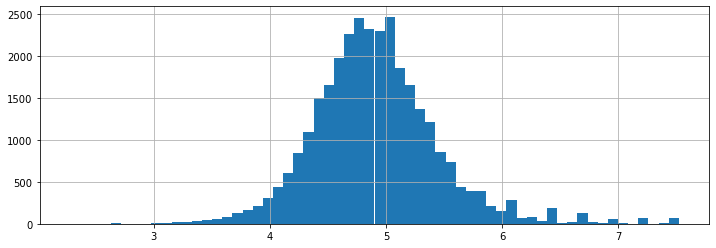

In [10]:
# Of the remaining movies, filter out those that have a mean + 1.5x std of rating below 4.4.
movie['stat_score'] = movie['mean'] + 1.5 * movie['std']
movie['stat_score'].hist(bins=60, figsize=(12,4))

In [11]:
thumbs_up = movie[movie['stat_score'] >= 4.4]

In [12]:
thumbs_up = thumbs_up.drop(columns=['userId','4.5+ star'])
thumbs_up.shape

(26914, 4)

In [13]:
thumbs_up.head(2)

,count,mean,std,stat_score
movieId,,,,
1,57309,3.893708,0.921552,5.276036
2,24228,3.251527,0.959851,4.691304


### *Too few ratings* filter

In [14]:
thumbs_up = thumbs_up[thumbs_up['count']>10]

In [15]:
thumbs_up.count()

count         17683
mean          17683
std           17683
stat_score    17683
dtype: int64

In [16]:
thumbs_up.head(3)

,count,mean,std,stat_score
movieId,,,,
1,57309,3.893708,0.921552,5.276036
2,24228,3.251527,0.959851,4.691304
3,11804,3.142028,1.008443,4.654692


### Apply filter to links file to get a good list for web scraping of movies.

In [18]:
movie_list = pd.read_csv('data/links.csv')

In [19]:
filtered_movies = movie_list.merge(thumbs_up, how='inner', left_on='movieId', right_on='movieId')

In [23]:
filtered_movies.head(1)

,movieId,imdbId,tmdbId,count,mean,std,stat_score
0,1,114709,862.0,57309,3.893708,0.921552,5.276036


In [25]:
filtered_movies.to_csv('data/filtered_links.csv', index=False)

### Apply 'thumbs up' filter to ratings data table

In [ ]:
thumbs_up_ratings = ratings_df.merge(thumbs_up, how='inner', left_on='movieId', right_on='movieId')

In [ ]:
thumbs_up_ratings.tail(2) # Filtered ratings db

In [24]:
thumbs_up_ratings.to_csv('data/filtered_ratings.csv', index=False)

NameError: name 'thumbs_up_ratings' is not defined

# Create a bad movie drop filter

In [20]:
good_movies = two_filter_ratings.groupby('movie').count()

In [312]:
all_movies = ratings_df.groupby('movie').count()

In [313]:
all_movies.head()

,user,rating
movie,,
1,1749,1749
2,566,566
3,382,382
4,134,134
5,237,237


In [331]:
null_set = all_movies.merge(good_movies, how='outer', left_on='movie', right_on='movie')

In [332]:
null_set

,user_x,rating_x,user_y,rating_y,stat_score
movie,,,,,
1,1749,1749,1749.0,1749.0,1749.0
2,566,566,NaN,NaN,NaN
3,382,382,NaN,NaN,NaN
4,134,134,NaN,NaN,NaN
5,237,237,NaN,NaN,NaN
...,...,...,...,...,...
3948,450,450,450.0,450.0,450.0
3949,76,76,76.0,76.0,76.0
3950,15,15,15.0,15.0,15.0


In [334]:
null = null_set[null_set.isnull().any(axis=1)]

In [336]:
null.columns

Index(['user_x', 'rating_x', 'user_y', 'rating_y', 'stat_score'], dtype='object')

In [339]:
null = null.drop(['user_x', 'rating_x', 'user_y', 'rating_y', 'stat_score'], axis = 1)

In [340]:
null.to_csv('data/movies_to_drop.csv')